In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/TestModel/'

/content/drive/MyDrive/TestModel


In [4]:
# import here
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

---
# Load The Data

In [12]:
# Load pickled data
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [13]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


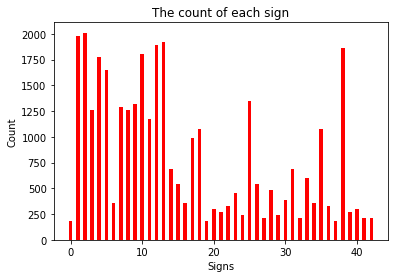

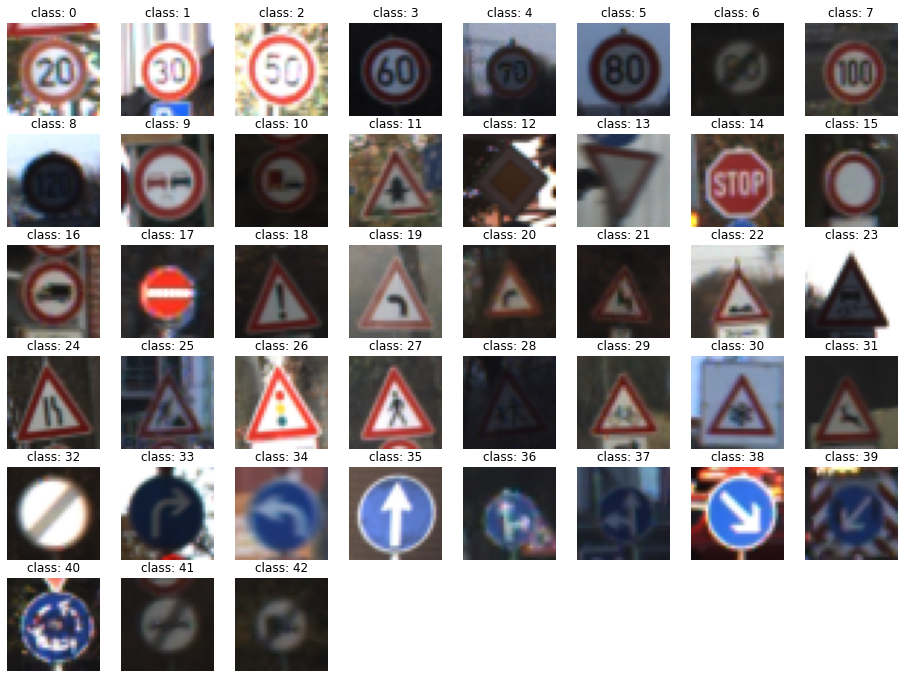

In [14]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [15]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [16]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

## Baseline Model

In [17]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [18]:
torch.manual_seed(1)

In [19]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

In [42]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [21]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [49]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    plt.figure(figsize=(16, 16))
    c=0
    for i in range(len(correct)):
      c+=1
      if c==16:
        break
      if correct[i]==False:
            plt.subplot(8, 8, c+1)
            plt.axis('off')
            plt.title('Original: {} Pred {}'.format(y[i],pred[i]))
            #plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')
            plt.imshow(x[i][0].to('cpu'),cmap='gray')
    #print(len(pred))
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [22]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_loss_list=[]
    val_loss_list=[]
    val_acc_list=[]
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        train_loss_list.append(train_loss)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            val_loss_list.append(valid_loss)
            val_acc_list.append(valid_accuracy)
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accuracy: {valid_accuracy:.3f}%")
    return  train_loss_list,val_loss_list,val_acc_list      

In [7]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [47]:
tr_loss_list,vl_loss_list,vl_accuracy_list=fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.692788	Validation loss: 3.584665	 Validation accuracy: 5.465%
[Epoch 2/20] Train loss: 3.483658	Validation loss: 3.562204	 Validation accuracy: 5.170%
[Epoch 3/20] Train loss: 3.446412	Validation loss: 3.524812	 Validation accuracy: 7.438%
[Epoch 4/20] Train loss: 3.275720	Validation loss: 3.207783	 Validation accuracy: 19.048%
[Epoch 5/20] Train loss: 2.581165	Validation loss: 2.262922	 Validation accuracy: 42.018%
[Epoch 6/20] Train loss: 1.685444	Validation loss: 1.553265	 Validation accuracy: 56.281%
[Epoch 7/20] Train loss: 1.195394	Validation loss: 1.192205	 Validation accuracy: 68.798%
[Epoch 8/20] Train loss: 0.909531	Validation loss: 1.032655	 Validation accuracy: 72.562%
[Epoch 9/20] Train loss: 0.746720	Validation loss: 0.948205	 Validation accuracy: 73.107%
[Epoch 10/20] Train loss: 0.642131	Validation loss: 0.921430	 Validation accuracy: 74.807%
[Epoch 11/20] Train loss: 0.547721	Validation loss: 0.782571	 Validation accuracy: 78.209%
[Epoch 12/2

## Plots for Baseline

In [ ]:
epoch_list=[i for i in range(1,21)]
plt.lin

---
# Experiment and find tuning

## Data preprocessing

In [23]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

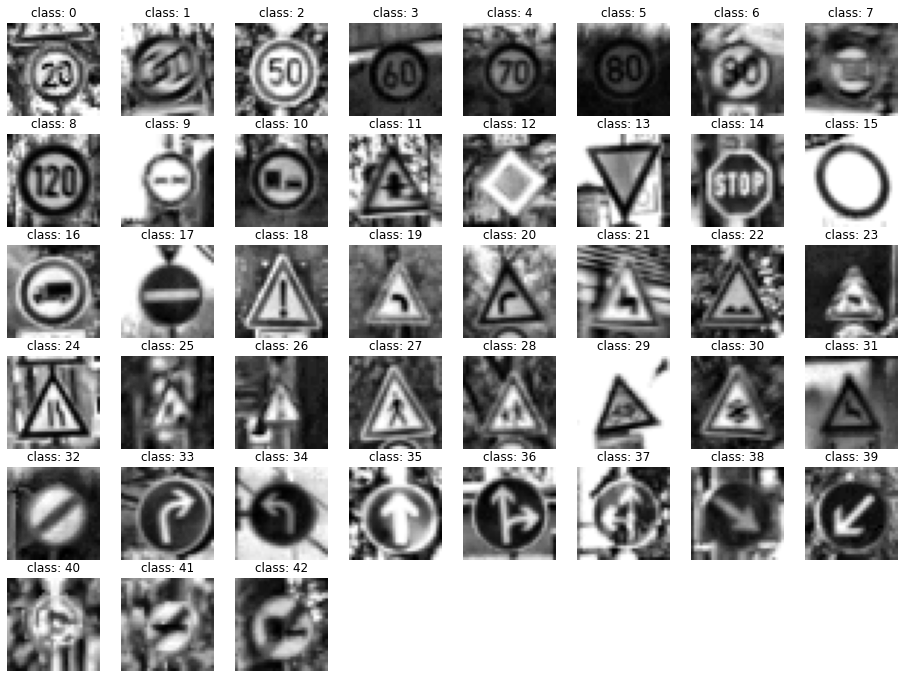

In [24]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [25]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.708688	Validation loss: 3.626302	 Validation accruacy: 5.057%
[Epoch 2/20] Train loss: 3.486799	Validation loss: 3.554802	 Validation accruacy: 6.122%
[Epoch 3/20] Train loss: 3.452667	Validation loss: 3.516018	 Validation accruacy: 14.853%
[Epoch 4/20] Train loss: 3.282134	Validation loss: 3.075970	 Validation accruacy: 22.313%
[Epoch 5/20] Train loss: 2.230607	Validation loss: 1.747565	 Validation accruacy: 51.859%
[Epoch 6/20] Train loss: 1.242539	Validation loss: 1.107964	 Validation accruacy: 67.234%
[Epoch 7/20] Train loss: 0.833010	Validation loss: 0.762036	 Validation accruacy: 78.458%
[Epoch 8/20] Train loss: 0.620127	Validation loss: 0.704410	 Validation accruacy: 78.458%
[Epoch 9/20] Train loss: 0.496232	Validation loss: 0.563285	 Validation accruacy: 82.358%
[Epoch 10/20] Train loss: 0.410226	Validation loss: 0.513028	 Validation accruacy: 84.399%
[Epoch 11/20] Train loss: 0.345770	Validation loss: 0.488947	 Validation accruacy: 85.737%
[Epoch 12/

## Save preprocessed images

In [26]:
def preprocess(path):
    if not os.path.exists(f"{path}/train_gray.p"):
        for dataset in ['train', 'valid', 'test']:
            with open(f"{path}/{dataset}.p", mode='rb') as f:
                data = pickle.load(f)
                X = data['features']
                y = data['labels']

            clahe = CLAHE_GRAY()
            for i in range(len(X)):
                X[i] = clahe(X[i])

            X = X[:, :, :, 0]
            with open(f"{path}/{dataset}_gray.p", "wb") as f:
                pickle.dump({"features": X.reshape(
                    X.shape + (1,)), "labels": y}, f)

In [27]:
preprocess('data')
training_file = 'data/train_gray.p'
validation_file = "data/valid_gray.p"
testing_file = "data/test_gray.p"

In [28]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

## Handling imbalanced dataset

### Flipping

In [29]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [30]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)

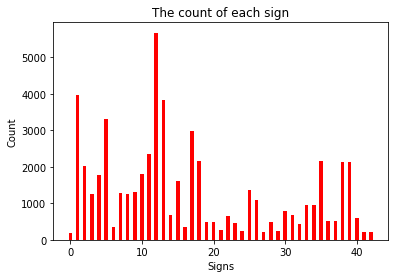

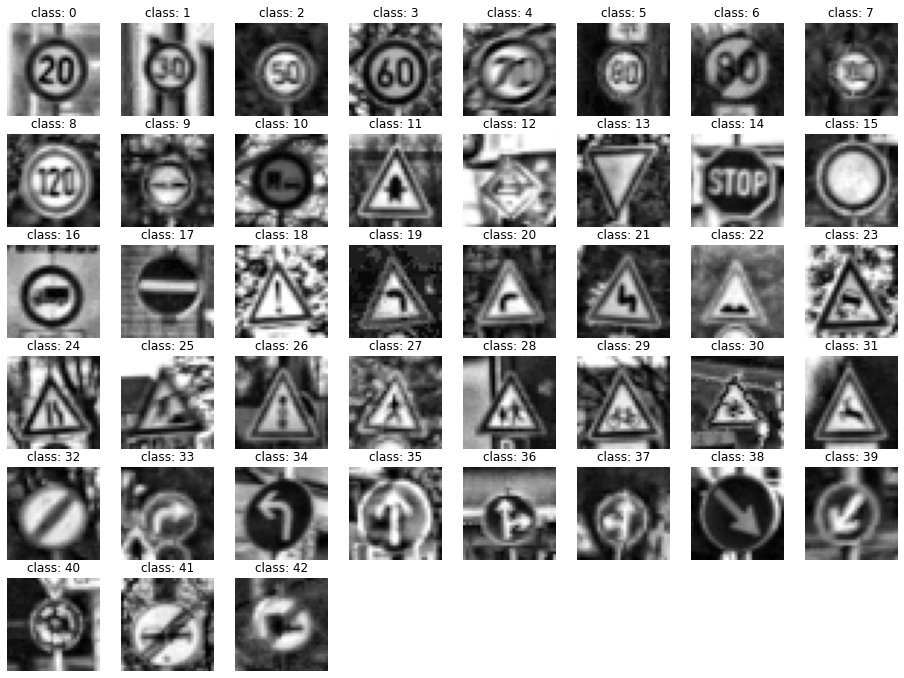

In [31]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i].squeeze(), cmap='gray')

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.508843	Validation loss: 3.620161	 Validation accruacy: 4.785%
[Epoch 2/20] Train loss: 3.088180	Validation loss: 2.750377	 Validation accruacy: 26.757%
[Epoch 3/20] Train loss: 1.614141	Validation loss: 1.383829	 Validation accruacy: 61.156%
[Epoch 4/20] Train loss: 0.877774	Validation loss: 0.893878	 Validation accruacy: 73.243%
[Epoch 5/20] Train loss: 0.609346	Validation loss: 0.713786	 Validation accruacy: 79.161%
[Epoch 6/20] Train loss: 0.458022	Validation loss: 0.558191	 Validation accruacy: 83.605%
[Epoch 7/20] Train loss: 0.368242	Validation loss: 0.487707	 Validation accruacy: 85.601%
[Epoch 8/20] Train loss: 0.307339	Validation loss: 0.455157	 Validation accruacy: 87.279%
[Epoch 9/20] Train loss: 0.259482	Validation loss: 0.414473	 Validation accruacy: 87.483%
[Epoch 10/20] Train loss: 0.224488	Validation loss: 0.376955	 Validation accruacy: 89.728%
[Epoch 11/20] Train loss: 0.197035	Validation loss: 0.337314	 Validation accruacy: 89.909%
[Epoch 12

### Augmentation

In [32]:
train_dataset = extend_dataset(PickledDataset(training_file))

class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 20000)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)

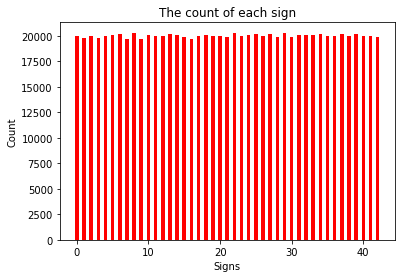

In [33]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [34]:
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.ToTensor()

train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [35]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img

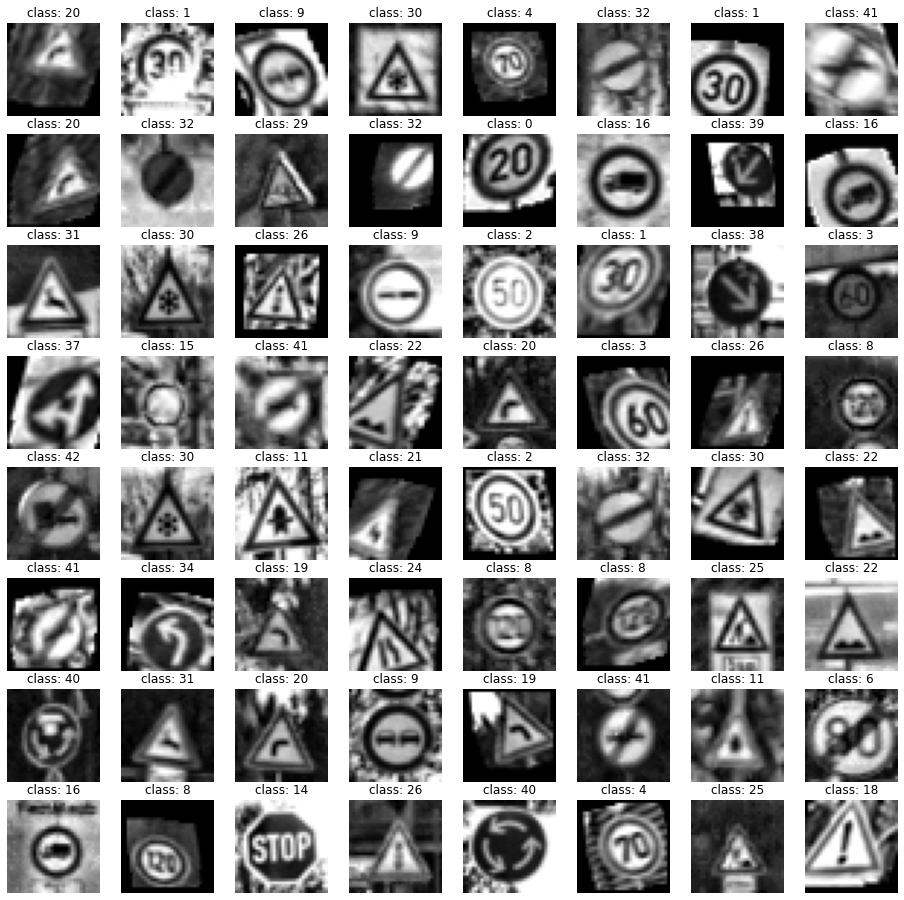

In [36]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 2.380466	Validation loss: 0.574594	 Validation accruacy: 81.995%
[Epoch 2/20] Train loss: 0.767553	Validation loss: 0.346210	 Validation accruacy: 90.567%
[Epoch 3/20] Train loss: 0.512051	Validation loss: 0.310381	 Validation accruacy: 92.018%
[Epoch 4/20] Train loss: 0.407675	Validation loss: 0.279048	 Validation accruacy: 91.655%
[Epoch 5/20] Train loss: 0.346381	Validation loss: 0.281919	 Validation accruacy: 93.129%
[Epoch 6/20] Train loss: 0.304579	Validation loss: 0.271469	 Validation accruacy: 94.036%
[Epoch 7/20] Train loss: 0.275263	Validation loss: 0.301138	 Validation accruacy: 92.834%
[Epoch 8/20] Train loss: 0.250592	Validation loss: 0.282794	 Validation accruacy: 93.673%
[Epoch 9/20] Train loss: 0.232405	Validation loss: 0.248254	 Validation accruacy: 94.558%
[Epoch 10/20] Train loss: 0.218885	Validation loss: 0.238033	 Validation accruacy: 94.558%
[Epoch 11/20] Train loss: 0.204253	Validation loss: 0.232611	 Validation accruacy: 93.832%
[Epoch 1

## Model

In [ ]:
# class TrafficSignNet(nn.Module):
#     def __init__(self):
#         super(TrafficSignNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 100, 5)
#         self.conv1_bn = nn.BatchNorm2d(100)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(100, 150, 3)
#         self.conv2_bn = nn.BatchNorm2d(150)
#         self.conv3 = nn.Conv2d(150, 250, 1)
#         self.conv3_bn = nn.BatchNorm2d(250)
#         self.fc1 = nn.Linear(250 * 3 * 3, 350)
#         self.fc1_bn = nn.BatchNorm1d(350)
#         self.fc2 = nn.Linear(350, 43)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = self.pool(F.elu(self.conv1(x)))
#         x = self.dropout(self.conv1_bn(x))
#         x = self.pool(F.elu(self.conv2(x)))
#         x = self.dropout(self.conv2_bn(x))
#         x = self.pool(F.elu(self.conv3(x)))
#         x = self.dropout(self.conv3_bn(x))
#         x = x.view(-1, 250 * 3 * 3)
#         x = F.elu(self.fc1(x))
#         x = self.dropout(self.fc1_bn(x))
#         x = self.fc2(x)
#         return x

In [ ]:
# class TrafficSignNet(nn.Module):
#     def __init__(self):
#         super(TrafficSignNet, self).__init__()
#         self.conv1 = nn.Conv2d(1,32, 5)
#         self.conv1_bn = nn.BatchNorm2d(32)
#         self.pool = nn.MaxPool2d(8)
#         self.conv2 = nn.Conv2d(32, 64, 5)
#         self.conv2_bn = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, 5)
#         self.conv3_bn = nn.BatchNorm2d(128)
#         self.fc1 = nn.Linear(1152, 1024)
#         self.fc1_bn = nn.BatchNorm1d(1024)
#         self.fc2 = nn.Linear(1024, 43)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x_block_1 = self.conv1_bn(F.relu(self.conv1(x)))
#         x_block_1 = self.pool(F.relu(self.conv1(x_block_1)))
#         x_block_1 = self.dropout(self.conv1_bn(x_block_1))
#         x_block_2 = self.conv2_bn(F.relu(self.conv2(x_block_1)))
#         x_block_2 = self.pool(F.relu(self.conv2(x_block_2)))
#         x_block_2 = self.dropout(self.conv2_bn(x_block_2))
#         x_block_3 = self.conv3_bn(F.relu(self.conv3(x_block_2)))
#         x_block_3 = self.pool(F.relu(self.conv3(x_block_3)))
#         x_block_3 = self.dropout(self.conv3_bn(x_block_3))
#         x_block_1_fl=x_block_1.view(-1,15488)
#         x_block_2_fl=x_block_2.view(-1,9216)
#         x_block_3_fl=x_block_3.view(-1,512)
#         x=torch.cat([x_block_1_fl,x_block_2_fl,x_block_3_fl],0)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(self.fc1_bn(x))
#         x=self.fc2(x)
#         x=self.dropout(x)
#         return x

In [5]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        
        # Constraints for layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride = 1, padding=2)
        self.batch1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2) #default stride is equivalent to the kernel_size
        
        # Constraints for layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride = 1, padding=2)
        self.batch2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Defining the Linear layer
        self.fc1 = nn.Linear(2048,1024)
        self.dropout = nn.Dropout(p=0.5)
        # Defining the Linear layer
        self.fc2 = nn.Linear(1024,256)
        self.dropout1 = nn.Dropout(p=0.5)
        # Defining the Linear layer
        self.fc3 = nn.Linear(256,43)
        
        
    
    # defining the network flow
    def forward(self, x):
          # Conv 1
          out = self.conv1(x)
          out = self.batch1(out)
          out = self.relu1(out)
          
          # Max Pool 1
          out = self.pool1(out)
          
          # Conv 2
          out = self.conv2(out)
          out = self.batch2(out)
          out = self.relu2(out)
          
          # Max Pool 2
          out = self.pool2(out)
          
          out = out.view(out.size(0),-1)
          # Linear Layer
          out = self.fc1(out)
          out=self.dropout(out)
          # Linear layer
          out = self.fc2(out)
          out=self.dropout1(out)
          # Linear layer
          out = self.fc3(out)
          return out

In [ ]:
TrafficSignNet()

TrafficSignNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=43, bias=True)
)

In [ ]:
# class TrafficSignNet(nn.Module):
#       def __init__(self):
#           # call the parent constructor
#           super(TrafficSignNet, self).__init__()

#           # initialize first set of CONV => RELU => POOL layers
#           self.conv1 = nn.Conv2d(in_channels=1, out_channels=20,
#           kernel_size=(5, 5))
#           self.relu1 = nn.ReLU()
#           self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

#           # initialize second set of CONV => RELU => POOL layers
#           self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,
#           kernel_size=(5, 5))
#           self.relu2 = nn.ReLU()
#           self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

#           # initialize first (and only) set of FC => RELU layers
#           self.fc1 = nn.Linear(in_features=800, out_features=500)
#           self.relu3 = nn.ReLU()

#           # initialize our softmax classifier
#           self.fc2 = nn.Linear(in_features=500, out_features=43)
#           self.logSoftmax = nn.LogSoftmax(dim=1)
    
#     # defining the network flow
#       def forward(self, x):
#           # pass the input through our first set of CONV => RELU =>
#           # POOL layers
#           x = self.conv1(x)
#           x = self.relu1(x)
#           x = self.maxpool1(x)

#           # pass the output from the previous layer through the second
#           # set of CONV => RELU => POOL layers
#           x = self.conv2(x)
#           x = self.relu2(x)
#           x = self.maxpool2(x)

#           # flatten the output from the previous layer and pass it
#           # through our only set of FC => RELU layers
#           x = x.view(x.size(0),-1)
#           x = self.fc1(x)
#           x = self.relu3(x)

#           # pass the output to our softmax classifier to get our output
#           # predictions
#           x = self.fc2(x)
#           output = self.logSoftmax(x)

#           # return the output predictions
#           return output  

In [37]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return

In [38]:
n_epochs = 20
cnn_model= TrafficSignNet().to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
fit(n_epochs, cnn_model, criterion, optimizer, train_loader, valid_loader)

NameError: ignored

In [ ]:
torch.save(cnn_model.state_dict(), 'CNN_model.pt')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test loss: 0.210006	Test accruacy: 96.698%


<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

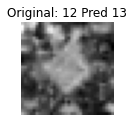

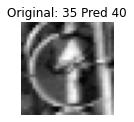

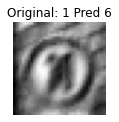

<Figure size 1152x1152 with 0 Axes>

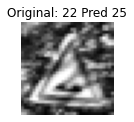

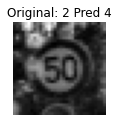

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

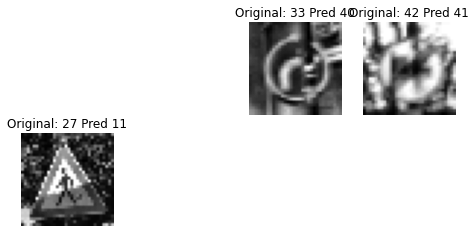

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

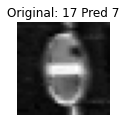

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

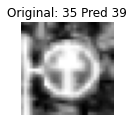

<Figure size 1152x1152 with 0 Axes>

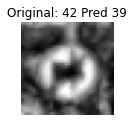

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

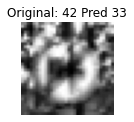

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

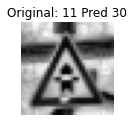

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

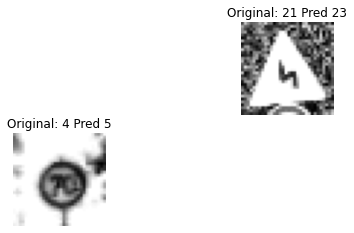

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

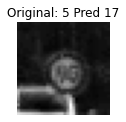

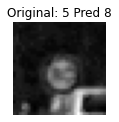

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

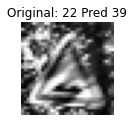

<Figure size 1152x1152 with 0 Axes>

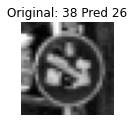

<Figure size 1152x1152 with 0 Axes>

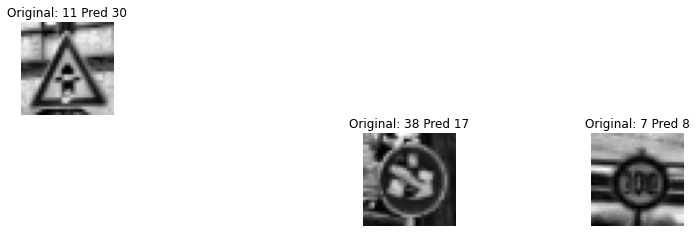

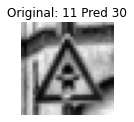

<Figure size 1152x1152 with 0 Axes>

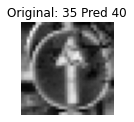

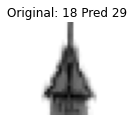

<Figure size 1152x1152 with 0 Axes>

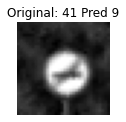

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

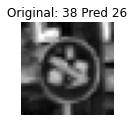

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

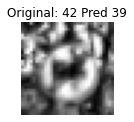

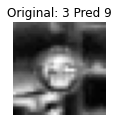

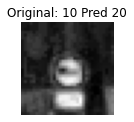

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

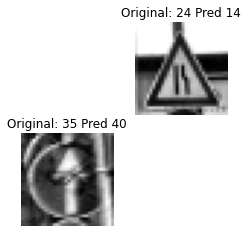

<Figure size 1152x1152 with 0 Axes>

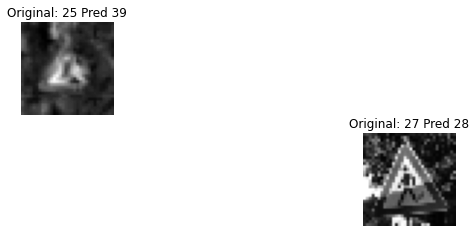

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

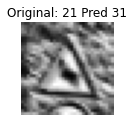

<Figure size 1152x1152 with 0 Axes>

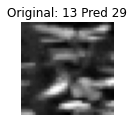

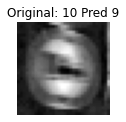

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

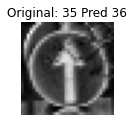

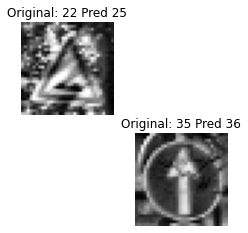

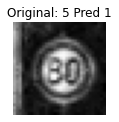

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

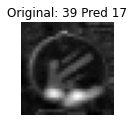

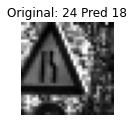

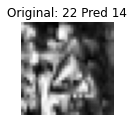

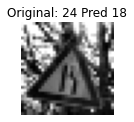

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

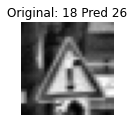

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

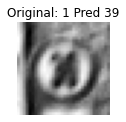

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

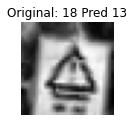

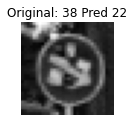

<Figure size 1152x1152 with 0 Axes>

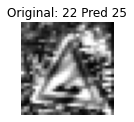

<Figure size 1152x1152 with 0 Axes>

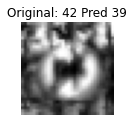

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

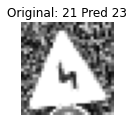

<Figure size 1152x1152 with 0 Axes>

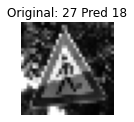

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

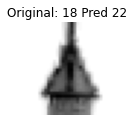

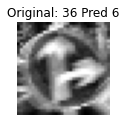

<Figure size 1152x1152 with 0 Axes>

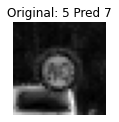

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

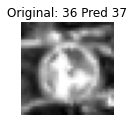

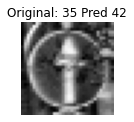

<Figure size 1152x1152 with 0 Axes>

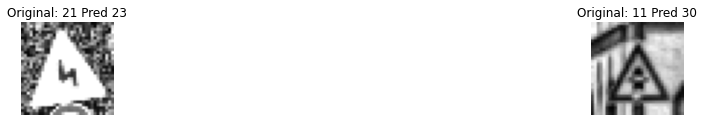

<Figure size 1152x1152 with 0 Axes>

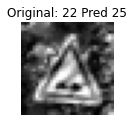

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

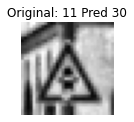

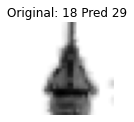

<Figure size 1152x1152 with 0 Axes>

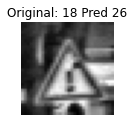

<Figure size 1152x1152 with 0 Axes>

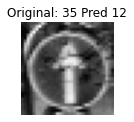

<Figure size 1152x1152 with 0 Axes>

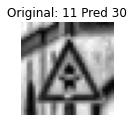

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

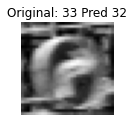

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

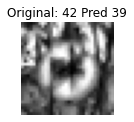

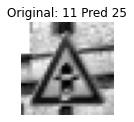

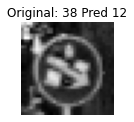

<Figure size 1152x1152 with 0 Axes>

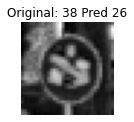

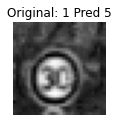

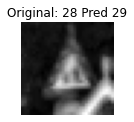

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

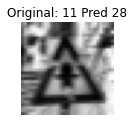

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

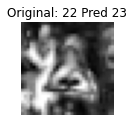

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

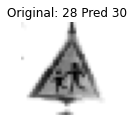

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

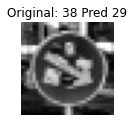

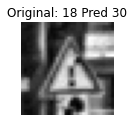

In [50]:
cnn_model= TrafficSignNet().to(device)
check_point = torch.load('CNN_model.pt', map_location=device)
criterion = nn.CrossEntropyLoss()
cnn_model.load_state_dict(check_point)
evaluate(cnn_model, criterion, test_loader)

**Confusion Matrix**

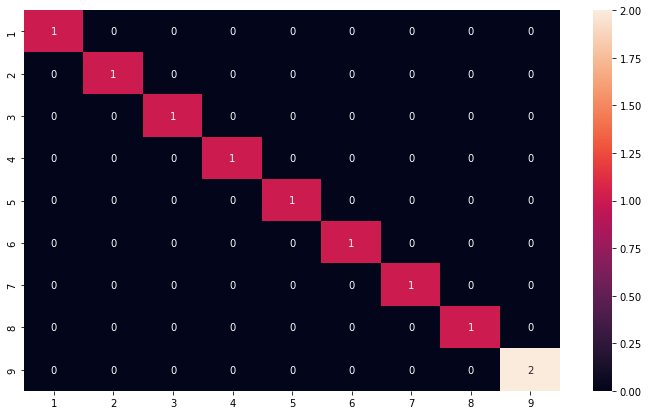

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = cnn_model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('1','2','3','4','5','6','7','8','9')#'10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40','41','42','43')
# Build confusion matrix
cf_matrix = confusion_matrix(y_true[:10], y_pred[:10])
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)